# Installs & Imports

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel, GenericLikelihoodModelResults
from statsmodels.discrete.discrete_model import Poisson, NegativeBinomial
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from scipy.stats import poisson, nbinom
from scipy.special import logsumexp, gammaln
import matplotlib.pyplot as plt
import warnings

# Suppress UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

# Generate Data

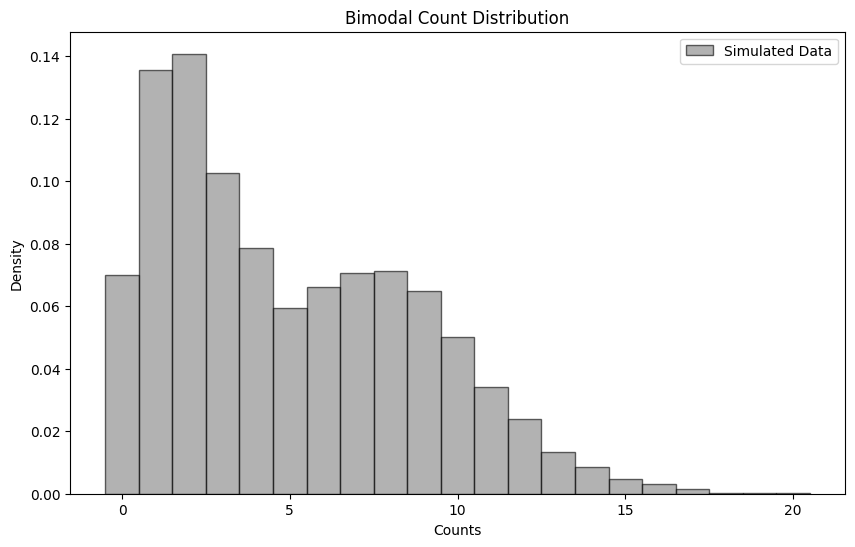

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
n_samples = 10000

# Component 1: Poisson with lambda=2
counts1 = np.random.poisson(2, size=int(0.5 * n_samples))

# Component 2: Poisson with lambda=8
counts2 = np.random.poisson(8, size=int(0.5 * n_samples))

# Combine counts
counts = np.concatenate([counts1, counts2])

# Generate covariates
x1 = np.random.normal(0, 1, size=n_samples)
x2 = np.random.normal(0, 1, size=n_samples)
data = pd.DataFrame({'counts': counts, 'x1': x1, 'x2': x2})

# Shuffle data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=np.arange(counts.max()+2) - 0.5, density=True, alpha=0.6,
         color='gray', edgecolor='black')
plt.xlabel('Counts')
plt.ylabel('Density')
plt.title('Bimodal Count Distribution')
plt.legend(['Simulated Data'])
plt.show()

# Split Data

In [3]:
# Define train-test split
train_fraction = 0.8
train_size = int(n_samples * train_fraction)

train_data = data.iloc[:train_size].reset_index(drop=True)
test_data = data.iloc[train_size:].reset_index(drop=True)

print(f"Training set size: {train_data.shape[0]}")
print(f"Testing set size: {test_data.shape[0]}")

Training set size: 8000
Testing set size: 2000


# Poisson Model

In [4]:
# Fit Poisson Model
poisson_model = sm.GLM(
    train_data['counts'],
    sm.add_constant(train_data[['x1', 'x2']]),
    family=sm.families.Poisson()
)
poisson_result = poisson_model.fit()

# Display summary
print("Poisson Model Summary:")
print(poisson_result.summary())
print("\n")
print(poisson_result.summary2())

Poisson Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 counts   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7997
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24418.
Date:                Thu, 28 Nov 2024   Deviance:                       24373.
Time:                        10:25:52   Pearson chi2:                 2.27e+04
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0003250
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6052      0.

# Negative Binomial Model

In [5]:
# Fit Negative Binomial Model
nb_model = NegativeBinomial(
    endog=train_data['counts'],
    exog=sm.add_constant(train_data[['x1', 'x2']])
)
nb_result = nb_model.fit()

# Display summary
print("\nNegative Binomial Model Summary:")
print(nb_result.summary())
print("\n")
print(nb_result.summary2())

# Access estimated alpha (dispersion parameter)
print(f"\nEstimated alpha (dispersion): {nb_result.params['alpha']}")

Optimization terminated successfully.
         Current function value: 2.625797
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8

Negative Binomial Model Summary:
                     NegativeBinomial Regression Results                      
Dep. Variable:                 counts   No. Observations:                 8000
Model:               NegativeBinomial   Df Residuals:                     7997
Method:                           MLE   Df Model:                            2
Date:                Thu, 28 Nov 2024   Pseudo R-squ.:               1.910e-05
Time:                        10:25:53   Log-Likelihood:                -21006.
converged:                       True   LL-Null:                       -21007.
Covariance Type:            nonrobust   LLR p-value:                    0.6696
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const  

# Poisson Mixture Model

In [6]:
class PoissonMixtureModelResults(GenericLikelihoodModelResults):
    def __init__(self, model, mlefit, param_names):
        super(PoissonMixtureModelResults, self).__init__(model, mlefit)
        self._param_names = param_names

        # Create new attributes with parameter names
        self.named_params = pd.Series(self.params, index=self._param_names)
        if hasattr(self, 'bse'):
            self.named_bse = pd.Series(self.bse, index=self._param_names)
        if hasattr(self, 'tvalues'):
            self.named_tvalues = pd.Series(self.tvalues, index=self._param_names)
        if hasattr(self, 'pvalues'):
            self.named_pvalues = pd.Series(self.pvalues, index=self._param_names)

    def summary(self, yname=None, xname=None, title=None, alpha=.05):
        # Pass the parameter names to the summary
        if xname is None:
            xname = self._param_names
        return super(PoissonMixtureModelResults, self).summary(yname=yname, xname=xname, title=title, alpha=alpha)

In [7]:
class PoissonMixtureModel(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwargs):
        super(PoissonMixtureModel, self).__init__(endog, exog, **kwargs)
        # Store variable names
        if isinstance(exog, pd.DataFrame):
            self.var_names = exog.columns.tolist()
        else:
            self.var_names = [f'x{i+1}' for i in range(exog.shape[1])]

        # Set degrees of freedom attributes
        self.nobs = self.endog.shape[0]
        self.k_params = 2 * exog.shape[1] + 1  # Total number of parameters (beta1, beta2, gamma)
        self.k_constant = 2

        self.k_extra = 0

        # Calculate degrees of freedom
        self.df_model = self.k_params - self.k_constant - self.k_extra
        self.df_resid = self.nobs - self.k_params

    def nloglikeobs(self, params):
        # Ensure params is a NumPy array
        params = np.asarray(params)

        # Extract parameters
        num_vars = self.exog.shape[1]
        beta1 = params[0:num_vars]
        beta2 = params[num_vars:2*num_vars]
        gamma = params[-1]  # Mixing proportion parameter

        # Ensure mixing proportion is between 0 and 1 using logistic transformation
        pi1 = 1.0 / (1.0 + np.exp(-gamma))
        pi2 = 1 - pi1

        # Compute lambdas for each component
        X = self.exog
        lambda1 = np.exp(np.dot(X, beta1))
        lambda2 = np.exp(np.dot(X, beta2))

        y = self.endog

        # Compute the log-likelihood for each observation
        loglike1 = poisson.logpmf(y, lambda1)
        loglike2 = poisson.logpmf(y, lambda2)

        # Combine log-likelihoods using log-sum-exp for numerical stability
        loglikelihood = -logsumexp(
            np.vstack([np.log(pi1) + loglike1, np.log(pi2) + loglike2]),
            axis=0
        )

        return loglikelihood

    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwargs):
        num_vars = self.exog.shape[1]
        num_params = 2 * num_vars + 1  # beta1, beta2, gamma

        if start_params is None:
            # Use KMeans clustering to initialize parameters
            y = self.endog
            X = self.exog

            # Perform KMeans clustering on counts
            kmeans = KMeans(n_clusters=2, random_state=42)
            clusters = kmeans.fit_predict(y.reshape(-1, 1))

            # Fit Poisson regression to each cluster
            beta_initials = []
            for cluster_label in [0, 1]:
                idx = clusters == cluster_label
                y_cluster = y[idx]
                X_cluster = X[idx]
                poisson_model = Poisson(y_cluster, X_cluster)
                poisson_result = poisson_model.fit(disp=False)
                beta_initials.append(poisson_result.params)

            # Initial gamma (mixing proportion parameter)
            pi1 = np.mean(clusters == 0)
            gamma_initial = np.log(pi1 / (1 - pi1))

            # Combine initial parameters
            start_params = np.concatenate([beta_initials[0], beta_initials[1], [gamma_initial]])

        # Define parameter names using self.var_names
        param_names = []
        param_names += [f'Comp1_{name}' for name in self.var_names]
        param_names += [f'Comp2_{name}' for name in self.var_names]
        param_names += ['gamma']

        # Fit the model
        mlefit = super(PoissonMixtureModel, self).fit(
            start_params=start_params, maxiter=maxiter, **kwargs
        )

        # Return custom results object
        return PoissonMixtureModelResults(self, mlefit, param_names)

In [8]:
# Initialize and fit the model
pois_mixture_model = PoissonMixtureModel(
    endog=train_data['counts'],
    exog=sm.add_constant(train_data[['x1', 'x2']])
)
pois_mixture_result = pois_mixture_model.fit(method='bfgs')

# Display the summary
print("\nPoisson Mixture Model Summary:")
print(pois_mixture_result.summary())

Optimization terminated successfully.
         Current function value: 2.577489
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 14

Poisson Mixture Model Summary:
                          PoissonMixtureModel Results                          
Dep. Variable:                  counts   Log-Likelihood:                -20620.
Model:             PoissonMixtureModel   AIC:                         4.126e+04
Method:             Maximum Likelihood   BIC:                         4.134e+04
Date:                 Thu, 28 Nov 2024                                         
Time:                         10:25:57                                         
No. Observations:                 8000                                         
Df Residuals:                     7993                                         
Df Model:                            5                                         
                  coef    std err          z      P>|z|      [0.025      0.9

# NB Mixture Model

In [9]:
def negbinom_logpmf(y, mu, alpha):
    n = 1.0 / alpha
    p = n / (n + mu)
    # Ensure p is within (0,1) to avoid log(0)
    p = np.clip(p, 1e-10, 1 - 1e-10)
    # Compute log-likelihood
    loglik = (
        gammaln(y + n)
        - gammaln(n)
        - gammaln(y + 1)
        + n * np.log(p)
        + y * np.log(1 - p)
    )
    return loglik

In [10]:
class NegativeBinomialMixtureModelResults(GenericLikelihoodModelResults):
    def __init__(self, model, mlefit, param_names):
        super(NegativeBinomialMixtureModelResults, self).__init__(model, mlefit)
        self._param_names = param_names

        # Create new attributes with parameter names
        self.named_params = pd.Series(self.params, index=self._param_names)
        if hasattr(self, 'bse'):
            self.named_bse = pd.Series(self.bse, index=self._param_names)
        if hasattr(self, 'tvalues'):
            self.named_tvalues = pd.Series(self.tvalues, index=self._param_names)
        if hasattr(self, 'pvalues'):
            self.named_pvalues = pd.Series(self.pvalues, index=self._param_names)

    def summary(self, yname=None, xname=None, title=None, alpha=.05):
        # Pass the parameter names to the summary
        if xname is None:
            xname = self._param_names
        return super(NegativeBinomialMixtureModelResults, self).summary(yname=yname, xname=xname, title=title, alpha=alpha)

In [11]:
class NegativeBinomialMixtureModel(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwargs):
        super(NegativeBinomialMixtureModel, self).__init__(endog, exog, **kwargs)
        # Store variable names
        if isinstance(exog, pd.DataFrame):
            self.var_names = exog.columns.tolist()
        else:
            self.var_names = [f'x{i+1}' for i in range(exog.shape[1])]

        # Set degrees of freedom attributes
        self.nobs = self.endog.shape[0]
        # Number of parameters: beta1 (num_vars), beta2 (num_vars), alpha1, alpha2, gamma
        self.k_params = 2 * exog.shape[1] + 3  # Total number of parameters
        self.k_constant = 2

        self.k_extra = 0

        # Calculate degrees of freedom
        self.df_model = self.k_params - self.k_constant - self.k_extra
        self.df_resid = self.nobs - self.k_params

    def nloglikeobs(self, params):
        # Ensure params is a NumPy array
        params = np.asarray(params)

        # Extract parameters
        num_vars = self.exog.shape[1]
        beta1 = params[0:num_vars]
        beta2 = params[num_vars:2*num_vars]
        alpha1 = params[2*num_vars]
        alpha2 = params[2*num_vars + 1]
        gamma = params[-1]  # Mixing proportion parameter

        # Ensure mixing proportion is between 0 and 1 using logistic transformation
        pi1 = 1.0 / (1.0 + np.exp(-gamma))
        pi2 = 1 - pi1

        # Compute mu for each component
        X = self.exog
        mu1 = np.exp(np.dot(X, beta1))
        mu2 = np.exp(np.dot(X, beta2))

        y = self.endog

        # Compute the log-likelihood for each observation
        loglike1 = negbinom_logpmf(y, mu1, alpha1)
        loglike2 = negbinom_logpmf(y, mu2, alpha2)

        # Combine log-likelihoods using log-sum-exp for numerical stability
        loglikelihood = -logsumexp(
            np.vstack([np.log(pi1) + loglike1, np.log(pi2) + loglike2]),
            axis=0
        )

        return loglikelihood

    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwargs):
        num_vars = self.exog.shape[1]
        num_params = 2 * num_vars + 3  # beta1, beta2, alpha1, alpha2, gamma

        if start_params is None:
            # Use KMeans clustering to initialize parameters
            y = self.endog
            X = self.exog

            # Perform KMeans clustering on counts
            kmeans = KMeans(n_clusters=2, random_state=42)
            clusters = kmeans.fit_predict(y.reshape(-1, 1))

            # Fit Negative Binomial regression to each cluster
            beta_initials = []
            alpha_initials = []
            for cluster_label in [0, 1]:
                idx = clusters == cluster_label
                y_cluster = y[idx]
                X_cluster = X[idx]
                # We need to fit Negative Binomial model
                nb_model = sm.GLM(y_cluster, X_cluster, family=sm.families.NegativeBinomial())
                nb_result = nb_model.fit()
                beta_initials.append(nb_result.params)
                # Extract alpha (dispersion parameter)
                alpha_initials.append(nb_result.scale)

            # Initial gamma (mixing proportion parameter)
            pi1 = np.mean(clusters == 0)
            gamma_initial = np.log(pi1 / (1 - pi1))

            # Combine initial parameters
            start_params = np.concatenate([
                beta_initials[0],
                beta_initials[1],
                [alpha_initials[0]],
                [alpha_initials[1]],
                [gamma_initial]
            ])

        # Define parameter names using self.var_names
        param_names = []
        param_names += [f'Comp1_{name}' for name in self.var_names]
        param_names += [f'Comp2_{name}' for name in self.var_names]
        param_names += ['alpha1', 'alpha2', 'gamma']

        # Fit the model
        mlefit = super(NegativeBinomialMixtureModel, self).fit(
            start_params=start_params, maxiter=maxiter, **kwargs
        )

        # Return custom results object
        return NegativeBinomialMixtureModelResults(self, mlefit, param_names)

In [12]:
# Initialize and fit the model
nb_mixture_model = NegativeBinomialMixtureModel(
    endog=train_data['counts'],
    exog=sm.add_constant(train_data[['x1', 'x2']])
)
nb_mixture_result = nb_mixture_model.fit(method='bfgs')

# Display the summary
print("\nNegative Binomial Mixture Model Summary:")
print(nb_mixture_result.summary())

         Current function value: 2.593027
         Iterations: 28
         Function evaluations: 81
         Gradient evaluations: 73

Negative Binomial Mixture Model Summary:
                          NegativeBinomialMixtureModel Results                          
Dep. Variable:                           counts   Log-Likelihood:                -20744.
Model:             NegativeBinomialMixtureModel   AIC:                         4.152e+04
Method:                      Maximum Likelihood   BIC:                         4.162e+04
Date:                          Thu, 28 Nov 2024                                         
Time:                                  10:26:23                                         
No. Observations:                          8000                                         
Df Residuals:                              7991                                         
Df Model:                                     7                                         
                  coef 

# Model Evaluation

In [13]:
def evaluate_model(result, test_data, model_type):
    X_test = sm.add_constant(test_data[['x1', 'x2']], has_constant='add').values

    if model_type in ['Poisson', 'Negative Binomial']:
        # Predict using the model's predict method
        preds = result.predict(X_test)
    elif model_type == 'Poisson Mixture':
        # Extract parameters
        params = result.params
        num_vars = X_test.shape[1]
        beta1 = params[0:num_vars]
        beta2 = params[num_vars:2*num_vars]
        gamma = params[-1]

        # Mixing proportions
        pi1 = 1 / (1 + np.exp(-gamma))
        pi2 = 1 - pi1

        # Compute lambdas for each component
        lambda1 = np.exp(np.dot(X_test, beta1))
        lambda2 = np.exp(np.dot(X_test, beta2))

        # Expected counts
        preds = pi1 * lambda1 + pi2 * lambda2
    elif model_type == 'Negative Binomial Mixture':
        # Extract parameters
        params = result.params
        num_vars = X_test.shape[1]
        beta1 = params[0:num_vars]
        beta2 = params[num_vars:2*num_vars]
        alpha1 = params[2*num_vars]
        alpha2 = params[2*num_vars + 1]
        gamma = params[-1]

        # Mixing proportions
        pi1 = 1 / (1 + np.exp(-gamma))
        pi2 = 1 - pi1

        # Compute mu for each component
        mu1 = np.exp(np.dot(X_test, beta1))
        mu2 = np.exp(np.dot(X_test, beta2))

        # Expected counts
        preds = pi1 * mu1 + pi2 * mu2
    else:
        raise ValueError("Invalid model type")

    # Compute evaluation metrics
    rmse = np.sqrt(mean_squared_error(test_data['counts'], preds))
    mae = mean_absolute_error(test_data['counts'], preds)
    smape = 100 * np.mean(2 * np.abs(test_data['counts'] - preds) / (np.abs(test_data['counts']) + np.abs(preds)))

    return {'RMSE': rmse, 'MAE': mae, 'sMAPE': smape}

In [14]:
# Evaluate all models
poisson_eval = evaluate_model(poisson_result, test_data, "Poisson")
nb_eval = evaluate_model(nb_result, test_data, "Negative Binomial")
pm_eval = evaluate_model(pois_mixture_result, test_data, "Poisson Mixture")
nbm_eval = evaluate_model(nb_mixture_result, test_data, "Negative Binomial Mixture")

# Combine results into a DataFrame
evaluation_df = pd.DataFrame([
    poisson_eval,
    nb_eval,
    pm_eval,
    nbm_eval
], index=['Poisson', 'Negative Binomial', 'Poisson Mixture', 'NB Mixture'])

print("Prediction Metrics on Test Set:")
display(evaluation_df)

Prediction Metrics on Test Set:


,RMSE,MAE,sMAPE
Poisson,3.715157,3.163322,71.161007
Negative Binomial,3.715159,3.163326,71.161085
Poisson Mixture,3.715219,3.162747,71.147050
NB Mixture,3.731875,3.192232,71.400907


In [15]:
# Fit models on the entire dataset

# Poisson Model
poisson_model_full = sm.GLM(
    data['counts'],
    sm.add_constant(data[['x1', 'x2']]),
    family=sm.families.Poisson()
)
poisson_result_full = poisson_model_full.fit()

# Negative Binomial Model
nb_model_full = NegativeBinomial(
    endog=data['counts'],
    exog=sm.add_constant(data[['x1', 'x2']])
)
nb_result_full = nb_model_full.fit()

# Poisson Mixture Model
pm_model_full = PoissonMixtureModel(
    endog=data['counts'],
    exog=sm.add_constant(data[['x1', 'x2']])
)
pm_result_full = pm_model_full.fit(method='bfgs')

# Negative Binomial Mixture Model
nbm_model_full = NegativeBinomialMixtureModel(
    endog=data['counts'],
    exog=sm.add_constant(data[['x1', 'x2']])
)
nbm_result_full = nbm_model_full.fit(method='bfgs')

Optimization terminated successfully.
         Current function value: 2.626688
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 2.578015
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 14
         Current function value: 2.590892
         Iterations: 28
         Function evaluations: 85
         Gradient evaluations: 79


In [16]:
# Create a table for AIC and BIC
aic_bic_full = {
    "Model": ["Poisson", "Negative Binomial", "Poisson Mixture", "NB Mixture"],
    "AIC": [
        poisson_result_full.aic,
        nb_result_full.aic,
        pm_result_full.aic,
        nbm_result_full.aic
    ],
    "BIC": [
        poisson_result_full.bic_llf,
        nb_result_full.bic,
        pm_result_full.bic,
        nbm_result_full.bic
    ],
}
aic_bic_full_df = pd.DataFrame(aic_bic_full)
print("Information Criteria on Full Dataset:")
display(aic_bic_full_df)

Information Criteria on Full Dataset:


,Model,AIC,BIC
0,Poisson,60933.724684,60955.355705
1,Negative Binomial,52541.765600,52570.606962
2,Poisson Mixture,51582.302148,51661.615892
3,NB Mixture,51847.830946,51955.986051


# Expectation Maximization

In [17]:
from statsmodels.iolib.summary import Summary
from statsmodels.iolib.table import SimpleTable
from scipy.stats import norm
import time

In [18]:
class PoissonMixtureResults:
    def __init__(self, model, bootstrap_se=None):
        self.model = model
        self.params = model.params_  # Dictionary containing 'pi' and 'beta'
        self.nobs = model.n_obs
        self.k_params = self.model.n_components * self.model.n_vars + (self.model.n_components - 1)  # Number of parameters
        self.k_constant = self.model.n_components
        self.llf = self.model.llf
        self.aic = -2 * self.llf + 2 * self.k_params
        self.bic = -2 * self.llf + self.k_params * np.log(self.nobs)
        self.df_model = self.k_params - self.k_constant
        self.df_resid = self.nobs - self.k_params
        self.responsibilities = self.model.responsibilities_
        self.converged = self.model.converged

        # Initialize placeholders for standard errors, t-values, and p-values
        self.bse = None
        self.tvalues = None
        self.pvalues = None

        if bootstrap_se:
            self.pi_se = bootstrap_se['pi_se']
            self.beta_se = bootstrap_se['beta_se']
        else:
            self.pi_se = None
            self.beta_se = None

    def summary(self, yname=None, xname=None, title=None, alpha=0.05):
        """
        Generate a summary table similar to GenericLikelihoodModelResults.
        """
        # Prepare header information
        if yname is None:
            yname = 'counts'
        if xname is None:
            xname = self.model.var_names

        if title is None:
            title = 'Poisson Mixture Model Results'

        # Top-left table
        top_left = [
            ('Dep. Variable:', [yname]),  # Ensuring it's a list
            ('Model:', [self.model.__class__.__name__]),
            ('Method:', ['EM Algorithm']),
            ('Date:', [time.strftime("%a, %d %b %Y")]),
            ('Time:', [time.strftime("%H:%M:%S")]),
            ('No. Observations:', [f"{self.nobs}"]),
            ('Df Residuals:', [f"{self.df_resid}"]),
            ('Df Model:', [f"{self.df_model}"])
        ]

        # Top-right table
        top_right = [
            ('Log-Likelihood:', [f"{self.llf:.4f}"]),
            ('Converged:', [self.converged]),
            ('AIC:', [f"{self.aic:.4f}"]),
            ('BIC:', [f"{self.bic:.4f}"])
        ]

        # Create the summary object
        smry = Summary()
        smry.add_table_2cols(
            self,
            gleft=top_left,
            gright=top_right,
            title=title
        )

        # Prepare parameter estimates table
        param_data = []
        param_names = []

        # Collect parameters and their standard errors
        for k in range(self.model.n_components):
            for idx, name in enumerate(xname):
                param_name = f'Comp{k+1}_{name}'
                param_value = self.params['beta'][k][idx]
                if self.beta_se is not None:
                    se = self.beta_se[k][idx]
                    z = param_value / se
                    p = 2 * (1 - norm.cdf(np.abs(z)))  # Use scipy.stats.norm.cdf
                    ci_lower = param_value - 1.96 * se
                    ci_upper = param_value + 1.96 * se
                else:
                    se = np.nan
                    z = np.nan
                    p = np.nan
                    ci_lower = np.nan
                    ci_upper = np.nan
                param_data.append([param_value, se, z, p, ci_lower, ci_upper])
                param_names.append(param_name)

        # Mixing proportions (excluding the last one due to the constraint sum(pi) = 1)
        for k in range(self.model.n_components - 1):
            param_name = f'pi{k+1}'
            param_value = self.params['pi'][k]
            if self.pi_se is not None:
                se = self.pi_se[k]
                z = param_value / se
                p = 2 * (1 - norm.cdf(np.abs(z)))  # Use scipy.stats.norm.cdf
                ci_lower = param_value - 1.96 * se
                ci_upper = param_value + 1.96 * se
            else:
                se = np.nan
                z = np.nan
                p = np.nan
                ci_lower = np.nan
                ci_upper = np.nan
            param_data.append([param_value, se, z, p, ci_lower, ci_upper])
            param_names.append(param_name)

        # Convert to DataFrame and round
        params_table = pd.DataFrame(param_data, index=param_names, columns=['coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]'])
        params_table = params_table.round({'coef': 4, 'std err': 4, 'z': 3, 'P>|z|': 4, '[0.025': 4, '0.975]': 4})

        # Create a SimpleTable from the DataFrame
        params_simple_table = SimpleTable(
            params_table.values,
            headers=params_table.columns.tolist(),
            stubs=params_table.index.tolist(),
            title='Parameters',
            fmt=['%.4f', '%.4f', '%.3f', '%.4f', '%.4f', '%.4f']
        )

        # Add the parameters table to the summary
        smry.tables.append(params_simple_table)

        return smry

In [19]:
class PoissonMixtureModelEM:
    def __init__(self, endog, exog, n_components=2, max_iter=100, tol=1e-6, **kwargs):
        self.endog = endog.values if isinstance(endog, pd.Series) else endog
        self.exog = exog.values if isinstance(exog, pd.DataFrame) else exog
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.n_obs = self.endog.shape[0]
        self.n_vars = self.exog.shape[1]
        self.params_ = None  # To store the final parameters
        self.responsibilities_ = None  # To store the final responsibilities

        # Store variable names
        if isinstance(exog, pd.DataFrame):
            self.var_names = exog.columns.tolist()
        else:
            self.var_names = [f'x{i+1}' for i in range(self.n_vars)]

    def initialize_parameters(self):
        # Use KMeans clustering to initialize responsibilities
        kmeans = KMeans(n_clusters=self.n_components, random_state=42)
        clusters = kmeans.fit_predict(self.endog.reshape(-1, 1))

        # Initialize mixing proportions
        self.pi_ = np.array([np.mean(clusters == k) for k in range(self.n_components)])

        # Initialize coefficients for each component
        self.beta_ = []
        for k in range(self.n_components):
            idx = clusters == k
            y_cluster = self.endog[idx]
            X_cluster = self.exog[idx]
            if len(np.unique(y_cluster)) > 1:  # Ensure variability in counts
                poisson_model = sm.GLM(y_cluster, X_cluster, family=sm.families.Poisson())
                poisson_result = poisson_model.fit()
                self.beta_.append(poisson_result.params)
            else:
                # If all counts are the same in a cluster, set coefficients to zero
                self.beta_.append(np.zeros(self.n_vars))
        self.beta_ = np.array(self.beta_)

    def e_step(self):
        # Compute the Poisson rates for each component
        lambdas = []
        for k in range(self.n_components):
            lambda_k = np.exp(np.dot(self.exog, self.beta_[k]))
            lambdas.append(lambda_k)
        lambdas = np.array(lambdas)  # Shape: (n_components, n_obs)

        # Compute the log-likelihood for each component
        log_prob = []
        for k in range(self.n_components):
            # Compute the log PMF using gammaln for log(factorial)
            # Ensure lambdas[k] > 0 to avoid log(0)
            lambda_k = lambdas[k]
            lambda_k = np.clip(lambda_k, 1e-10, None)
            log_pmf = self.endog * np.log(lambda_k) - lambda_k - gammaln(self.endog + 1)
            log_prob.append(np.log(self.pi_[k]) + log_pmf)
        log_prob = np.array(log_prob)  # Shape: (n_components, n_obs)

        # Compute the responsibilities
        log_prob_norm = logsumexp(log_prob, axis=0)
        responsibilities = np.exp(log_prob - log_prob_norm)
        return responsibilities.T  # Shape: (n_obs, n_components)

    def m_step(self, responsibilities):
        # Update mixing proportions
        Nk = responsibilities.sum(axis=0)
        self.pi_ = Nk / self.n_obs

        # Update coefficients for each component
        for k in range(self.n_components):
            # Weighted Poisson regression
            weights = responsibilities[:, k]
            # To avoid division by zero in weights
            weights = np.clip(weights, 1e-10, None)
            poisson_model = sm.GLM(self.endog, self.exog, family=sm.families.Poisson(), freq_weights=weights)
            try:
                poisson_result = poisson_model.fit()
                self.beta_[k] = poisson_result.params
            except Exception as e:
                warnings.warn(f"Component {k+1}: Poisson regression failed with error {e}. Setting coefficients to zero.")
                self.beta_[k] = np.zeros(self.n_vars)

    def compute_log_likelihood(self):
        # Compute the Poisson rates for each component
        lambdas = []
        for k in range(self.n_components):
            lambda_k = np.exp(np.dot(self.exog, self.beta_[k]))
            lambdas.append(lambda_k)
        lambdas = np.array(lambdas)  # Shape: (n_components, n_obs)

        # Compute the log-likelihood for each component
        log_prob = []
        for k in range(self.n_components):
            lambda_k = lambdas[k]
            lambda_k = np.clip(lambda_k, 1e-10, None)  # Avoid log(0)
            log_pmf = self.endog * np.log(lambda_k) - lambda_k - gammaln(self.endog + 1)
            log_prob.append(np.log(self.pi_[k]) + log_pmf)
        log_prob = np.array(log_prob)  # Shape: (n_components, n_obs)

        # Total log-likelihood
        log_likelihood = np.sum(logsumexp(log_prob, axis=0))
        return log_likelihood

    def fit(self):
        self.initialize_parameters()
        log_likelihood_old = -np.inf
        self.converged = False  # Track convergence
        for iteration in range(1, self.max_iter + 1):
            # E-step
            responsibilities = self.e_step()

            # M-step
            self.m_step(responsibilities)

            # Compute log-likelihood
            log_likelihood_new = self.compute_log_likelihood()

            # Check for convergence
            if np.abs(log_likelihood_new - log_likelihood_old) < self.tol:
                # print(f"Converged at iteration {iteration}")
                self.converged = True
                break
            log_likelihood_old = log_likelihood_new
        else:
            print("Maximum iterations reached without convergence.")

        # Store final parameters
        self.params_ = {
            'pi': self.pi_,
            'beta': self.beta_
        }
        self.responsibilities_ = responsibilities
        self.llf = log_likelihood_new
        return self

    def predict(self, exog):
        exog = exog.values if isinstance(exog, pd.DataFrame) else exog
        lambdas = []
        for k in range(self.n_components):
            lambda_k = np.exp(np.dot(exog, self.beta_[k]))
            lambdas.append(lambda_k)
        lambdas = np.array(lambdas)  # Shape: (n_components, n_obs)

        # Expected counts
        expected_counts = np.dot(self.pi_, lambdas)
        return expected_counts

In [20]:
def bootstrap_se(model, n_bootstrap=100, random_state=42):
    np.random.seed(random_state)
    bootstrap_params = []
    indices = np.arange(model.n_obs)

    for i in range(n_bootstrap):
        # Resample indices with replacement
        resample_indices = np.random.choice(indices, size=model.n_obs, replace=True)
        endog_resampled = model.endog[resample_indices]
        exog_resampled = model.exog[resample_indices]

        # Fit the model to the resampled data
        bootstrap_model = PoissonMixtureModelEM(
            endog=endog_resampled,
            exog=exog_resampled,
            n_components=model.n_components,
            max_iter=model.max_iter,
            tol=model.tol
        )
        try:
            bootstrap_model.fit()
            bootstrap_params.append(bootstrap_model.params_)
        except:
            # If the model fails to converge, skip this bootstrap sample
            continue

    # Convert to lists for each parameter
    pi_list = []
    beta_list = []
    for param in bootstrap_params:
        pi_list.append(param['pi'])
        beta_list.append(param['beta'])

    # Convert to numpy arrays for easier computation
    pi_array = np.array(pi_list)  # Shape: (n_bootstrap, n_components)
    beta_array = np.array(beta_list)  # Shape: (n_bootstrap, n_components, n_vars)

    # Compute standard errors
    pi_se = np.std(pi_array, axis=0)
    beta_se = np.std(beta_array, axis=0)

    return {'pi_se': pi_se, 'beta_se': beta_se}

In [21]:
# Initialize and fit the model
pois_mixture_em = PoissonMixtureModelEM(
    endog=train_data['counts'],
    exog=sm.add_constant(train_data[['x1', 'x2']])
)
pois_mixture_em_result = pois_mixture_em.fit()

# Perform bootstrapping to estimate standard errors
bootstrap_results = bootstrap_se(pois_mixture_em, n_bootstrap=100)

# Create results object with bootstrapped standard errors
mixture_results = PoissonMixtureResults(pois_mixture_em, bootstrap_se=bootstrap_results)

# Display the summary
print("Poisson Mixture Model (EM) Summary:")
print(mixture_results.summary())

Poisson Mixture Model (EM) Summary:
                          Poisson Mixture Model Results                          
Dep. Variable:                    counts   Log-Likelihood:            -20619.9153
Model:             PoissonMixtureModelEM   Converged:                        True
Method:                     EM Algorithm   AIC:                        41253.8305
Date:                   Thu, 28 Nov 2024   BIC:                        41302.7409
Time:                           10:28:52                                         
No. Observations:                   8000                                         
Df Residuals:                       7993                                         
Df Model:                              5                                         
                       Parameters                       
              coef  std err   z    P>|z|   [0.025 0.975]
--------------------------------------------------------
Comp1_const  0.6881  0.6868  1.002 0.3164 -0.6581 2.034

# Model Re-Evaluation

In [22]:
# Make predictions
preds = pois_mixture_em.predict(sm.add_constant(test_data[['x1', 'x2']]))

In [23]:
def evaluate_model(preds, y_true):
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    mae = mean_absolute_error(y_true, preds)
    # To avoid division by zero, add a small epsilon
    epsilon = 1e-10
    smape = 100 * np.mean(2 * np.abs(y_true - preds) / (np.abs(y_true) + np.abs(preds) + epsilon))
    return {'RMSE': rmse, 'MAE': mae, 'sMAPE': smape}

In [24]:
# Evaluate prediction metrics
evaluation_metrics = evaluate_model(preds, test_data['counts'])
print("Prediction Metrics on Test Set:")
print(evaluation_metrics)

Prediction Metrics on Test Set:
{'RMSE': 3.715219408575426, 'MAE': 3.1627460103194593, 'sMAPE': 71.14704634930001}


In [25]:
# Add results to evaluation_df
evaluation_df_new = pd.DataFrame([evaluation_metrics], index=["Poisson Mixture (EM)"])
evaluation_df_combined = pd.concat([evaluation_df, evaluation_df_new])

# Display the combined DataFrame
display(evaluation_df_combined)

,RMSE,MAE,sMAPE
Poisson,3.715157,3.163322,71.161007
Negative Binomial,3.715159,3.163326,71.161085
Poisson Mixture,3.715219,3.162747,71.147050
NB Mixture,3.731875,3.192232,71.400907
Poisson Mixture (EM),3.715219,3.162746,71.147046


In [26]:
# Poisson Mixture Model (EM)
pois_mixture_em_full = PoissonMixtureModelEM(
    endog=data['counts'],
    exog=sm.add_constant(data[['x1', 'x2']])
)
pois_em_result_full = pois_mixture_em_full.fit()

# Perform bootstrapping to estimate standard errors
bootstrap_results_full = bootstrap_se(pois_mixture_em, n_bootstrap=100)

# Create results object with bootstrapped standard errors
pois_em_result_full2 = PoissonMixtureResults(pois_mixture_em, bootstrap_se=bootstrap_results_full)

# Compute AIC and BIC
pois_em_aic_full = pois_em_result_full2.aic
pois_em_bic_full = pois_em_result_full2.bic

# Add to AIC and BIC DataFrame
aic_bic_em_df = pd.DataFrame({
    "Model": ["Poisson Mixture (EM)"],
    "AIC": [pois_em_aic_full],
    "BIC": [pois_em_bic_full]
})

aic_bic_full_df = pd.concat([aic_bic_full_df, aic_bic_em_df], ignore_index=True)

print("Information Criteria on Full Dataset:")
display(aic_bic_full_df)

Information Criteria on Full Dataset:


,Model,AIC,BIC
0,Poisson,60933.724684,60955.355705
1,Negative Binomial,52541.765600,52570.606962
2,Poisson Mixture,51582.302148,51661.615892
3,NB Mixture,51847.830946,51955.986051
4,Poisson Mixture (EM),41253.830513,41302.740891
